<img align="center" src="figures/course.png" width="800">

#                                    16720 (B) Neural Networks for Recognition - Assignment 3

     Instructor: Kris Kitani                       TAs: Qichen(Lead), Paritosh, Rawal, Yan, Zen, Wen-Hsuan

## Q4 Extract Text from Images (35 points)

**Please include all the write up answers below to theory.ipynb. For the questions need code, you need to include the screenshot of code to theory.ipynb to get points.**

![](figures/annotatedLetters.jpg)
<center>Sample image with handwritten characters annotated with boxes around each character</center>

Now that you have a network that can recognize handwritten letters with reasonable accuracy, you can now use it to parse text in an image. Given an image with some text on it, our goal is to have a function that returns the actual text in the image. However, since your neural network expects a a binary image with a single character, you will need to process the input image to extract each character. There are various approaches that can be done so feel free to use any strategy you like.

Here we outline one possible method, another is that given in a [tutorial](http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html)
1. Process the image ([blur](http://scikit-image.org/docs/dev/auto_examples/filters/plot_denoise.html), [threshold](http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.try_all_threshold), [opening morphology](http://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.opening), etc. (perhaps in that order)) to classify all pixels as being part of a character or background.
2. Find connected groups of character pixels (see [skimage.measure.label](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label)). Place a bounding box around each connected component.
3. Group the letters based on which line of the text they are a part of, and sort each group so that the letters are in the order they appear on the page.
4. Take each bounding box one at a time and resize it to $32\times 32$, classify it with your network, and report the characters in order (inserting spaces when it makes sense).

Since the network you trained likely does not have perfect accuracy, you can expect there to be some errors in your final text parsing. Whichever method you choose to implement for the character detection, you should be able to place a box on most of there characters in the image. We have provided you with **01\_list.jpg**, **02\_letters.jpg**, **03\_haiku.jpg** and **04\_deep.jpg** to test your implementation on.

### Q4.1 (3 points WriteUp)
The method outlined above is pretty simplistic, and makes several assumptions. What are two big assumptions that the sample method makes. In your writeup, include two example images where you expect the character detection to fail (either miss valid letters, or respond to non-letters).

<font color="red">**Please include the write up answer to theory.ipynb**</font>

### Q4.2 (13 points Code+WriteUp)
Find letters in the image. Given an RGB image, this function should return bounding boxes for all of the located handwritten characters in the image, as well as a binary black-and-white version of the image \texttt{im}. Each row of the matrix should contain **[y1,x1,y2,x2]** the positions of the top-left and bottom-right corners of the box. The black and white image should be floating point, 0 to 1, with the characters in black and background in white. 

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

In [56]:
import numpy as np
import skimage
import skimage.measure
import skimage.color as sc
import skimage.restoration as sr
import skimage.io
import skimage.filters as sf
import skimage.morphology
from skimage.morphology import closing, square
import skimage.segmentation


def findLetters(image):
    bboxes = []
    
    bw = None
    # Calculating the noise in the image
    sig_est = sr.estimate_sigma(image, multichannel =True, average_sigmas=True)
    #print(sig_est)
    
    #Denosing the image
    de_image = sr.denoise_bilateral(image,sigma_color=sig_est ,multichannel= True) #Denoising
    
    #Converting to Greyscale and float
    gray = sc.rgb2gray(de_image) 
    gray = gray.astype('float')
    
    thresh = sf.threshold_otsu(gray) #taking threshold 
    
    #Performing morphology
    bw= closing(gray < thresh, square(8)) 
    
    #Removing artifacts in the border
    cleared = skimage.segmentation.clear_border(bw)

    # label image regions
    label_image = skimage.measure.label(cleared,connectivity=2) #background 1 as white is the req background 
    
    #Selecting the bounding boxes based on the mean are of the bounding boxes
    #Calculating the mean are
    meanarea = 0
    i=0
    for region in skimage.measure.regionprops(label_image):
        meanarea += region.area
        i +=1
    meanarea = meanarea/i
    
    #Looping throught each boundung boxes and finding the optimal ones 
    for region in skimage.measure.regionprops(label_image):
        if region.area >=meanarea/3:
        # draw rectangle around segmented image
            minr, minc, maxr, maxc = region.bbox
            bboxes.append([minr, minc, maxr, maxc])
        
   #inverting the image as the required output should be in yellow background (white when cmap = gray)
    bw = (1-bw)
    return bboxes, bw

### Q4.3 (6 points Code+WriteUp)
Run `findLetters()` on all of the provided sample images in **images/**. Plot all of the located boxes on top of the image to show the accuracy of your `findLetters()` function. Include all the result images in your writeup.

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

In [57]:
def sortedbb(img, thres):
    
    sorted = []

    #Reading the image
    im1 = skimage.img_as_float(skimage.io.imread(os.path.join('images',img)))
    
    # Extracting the bounding boxes
    bboxes, bw = findLetters(im1)
    plt.imshow(bw, cmap='gray')
    
    #Initialization for centers and height and width
    # For centers
    ybb = []
    xbb = []
    
    h = []
    w= []

    #Looping through bounding boxes
    for bbox in bboxes:
        minr, minc, maxr, maxc = bbox
        rect = matplotlib.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)
        
        #Centers
        ybb.append((bbox[2]+bbox[0])/2)
        xbb.append((bbox[1]+bbox[3])/2)
        #Height and width
        h.append(bbox[2]-bbox[0])
        w.append(bbox[3]-bbox[1])

    plt.show()
    
    #Taking the mean height and width in the boxes
    hm = np.mean(np.asarray(h))
    wm = np.mean(np.asarray(w))
    
    #print(hm//20, wm//20)
    
    #Creating a array with y coordinate, x coordinate of center and the initial arrangement
    ybb = np.asarray(ybb).reshape((-1,1))
    xbb = np.asarray(xbb).reshape((-1,1))
    id = np.asarray(np.arange(ybb.shape[0])).reshape((-1,1))
    #print(id)
    
    centerbb = np.hstack((ybb, xbb, id))
    
    #Sorting the center wrt to y axis
    idx = np.argsort(centerbb[:,0])
    
    ncenbb = np.copy(centerbb[idx,:])
    #print(ncenbb[:, 2].astype(int))
    
    #Sorting algorithm
    sort = []# Provides the indicies of boxes after sorting
    i =0
    print(ybb.shape[0])
    while(i < ybb.shape[0]):

        tmp = []
        
        if i==0:
            tmp.append(ncenbb[i,2])
            #print(ncenbb[i,2].astype(int))
            i +=1
        j =0
        
        #Clustering the rows based on a threshold
        while(((ncenbb[i+j,0] - ncenbb[i,0] ) < thres) ):
            tmp.append(ncenbb[i+j,2])
            #print(i+j)
            #print(ncenbb[i+j,2].astype(int))
            j+= 1
            if (i+j >= ybb.shape[0]):
                break
       
        #print(tmp)
        tid = np.asarray(tmp).astype(int)
        #print(tid)
        
        #Sorting the Clustered row wrt to xaxis
        tidx =np.argsort(centerbb[tid,1]).astype(int)
        #print(tid[tidx])

        #Stacking the cluested row into a list
        sort = np.hstack((sort, tid[tidx]))
        
        #Striding to the next row
        i = i + j
    #print(sort)
    #Cropping the bboxes and processsing it
    for i in sort:
        
        nb = np.asarray(bboxes)
        #print(nb[int(i),0])
        minr, minc, maxr, maxc =nb[int(i),:]
        
        h = int((maxr - minr))
        w = int((maxc - minc))
        h_pad, w_pad = 0, 0
        
        #For each images the padding value is different so padding based on the height and width value
        if h > w:
            h_pad = h//20
            w_pad = (h-w)//2+h_pad
        elif h < w:
            w_pad = w//20
            h_pad = (w-h)//2+w_pad
        
        # For square padding
        if h_pad> w_pad:
            pad = h_pad
        elif h_pad < w_pad:
            pad = w_pad
        
        #Aspect ratio Not required for this code
        r = w/h
        #print(h_pad, w_pad)
        
        crop = bw[minr:maxr, minc:maxc]
        
        crop = np.pad(crop, ((pad,pad), (pad,pad)), 'constant', constant_values=1.0)
        
        # For Refernce (Tuning the parameters)
        # if (img == '01_list.jpg'):
        #     crop = np.pad(crop, ((20, 20), (20, 20)), 'constant', constant_values=1.0)
        # else:
        #     crop = np.pad(crop, ((int(r*50), int(r*50)), (50, 50)), 'constant', constant_values=1.0)
        #*************************************
        crop =crop*255 #Needed before resizing
        crop_size = skimage.transform.resize(crop,(32,32), anti_aliasing=True)
        
        #resizing affected the values in the image, so nomalizing back to 0,1
        crop_size = (crop_size- np.min(crop_size))/(np.max(crop_size)- np.min(crop_size))
        #Intensifing the pixel values in the center
        crop_size = skimage.morphology.erosion(crop_size,  np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]]))
        

        # plt.imshow(crop_size)
        # plt.show()
        sorted.append(crop_size.T)

    
    return sorted
      


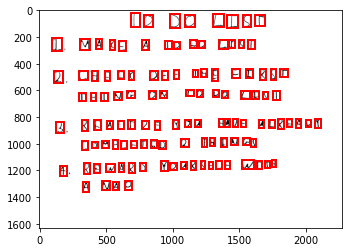

115


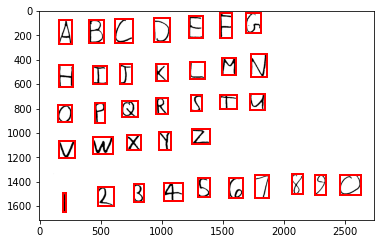

36


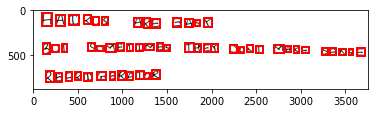

54


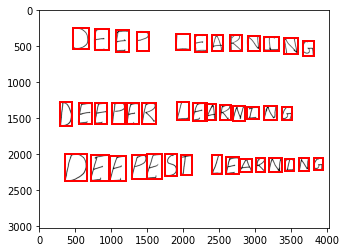

41


In [58]:
import  nbimporter
import os
import matplotlib.pyplot as plt
import matplotlib.patches
import q2
from q2 import *

# do not include any more libraries here!
# no opencv, no sklearn, etc!
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#Creating list of sorted bboxes for each images
sortedim1 =[]
sortedim2 = []
sortedim3 = []
sortedim4 =[]

for img in os.listdir('images'):
    if (img == '01_list.jpg'):
        sortedim1 = sortedbb(img, thres = 150)
    if (img == '02_letters.jpg'):
        sortedim2 = sortedbb(img, thres = 200)
    if (img == '03_haiku.jpg'):
        sortedim3 = sortedbb(img, thres = 200)
    if (img == '04_deep.jpg'):
        sortedim4 = sortedbb(img, thres = 200)
    
    

In [59]:
# Saving the bboxes in the pickle for q7
import pickle
# print(np.asarray(sortedim1).shape)
# print(np.asarray(sortedim2).shape)
# print(np.asarray(sortedim3).shape)
# print(np.asarray(sortedim4).shape)
with open('q4img1.pickle', 'wb') as handle:
    pickle.dump(sortedim1, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('q4img2.pickle', 'wb') as handle:
    pickle.dump(sortedim2, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('q4img3.pickle', 'wb') as handle:
    pickle.dump(sortedim3, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('q4img4.pickle', 'wb') as handle:
    pickle.dump(sortedim4, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Q4.4 (13 points Code+WriteUp)
Now you will load the image, find the character locations, classify each one with the network you trained in **Q3.1**, and return the text contained in the image. Be sure you try to make your detected images look like the images from the training set. Visualize them and act accordingly. 

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

In [60]:
#Trainging in the NN and classification
def getresult(x):
    st = ' '
    for i in range(x.shape[0]):
        img = x[i,:,:].reshape((-1,32*32)) #Reshaping according to the input need in NN
        #print(img.shape)
        
        postact1 = forward(img, params, 'layer1')
        postact2 = forward(postact1, params, 'output', softmax)
        #print(postact2.shape)
        
        idx = np.argmax(postact2[0, :])
        #print(idx)
        st = st + letters[idx] + ' ' 
    return st

In [61]:
# load the weights
# run the crops through your neural network and print them out
import pickle
import string
import numpy as np
x1 = np.array(sortedim1)
x2 = np.array(sortedim2)
x3 = np.array(sortedim3)
x4 = np.array(sortedim4)
letters = np.array([_ for _ in string.ascii_uppercase[:26]] + [str(_) for _ in range(10)])

#Importing parameters from q3
params = pickle.load(open('q3_weights.pickle','rb'))

Ans1 = 'T O D O L I S T 1 M A K E A T O D O L I S T 1 C H E C K O F F T H E F I R S T T H I N G O N T O D O L I S T 3 R E A L I Z E Y O U H A V E A L R E A D Y C O M P L E T E D 2 T H I N G S 4 R E W A R D Y O U R S E L F W I T H A N A P'
Ans2 = 'A B C D E F G H I J K L M N O P Q R S T U V W X Y Z 1 2 3 4 5 6 7 8 9 0'
Ans3 = 'H A I K U S A R E E A S Y B U T S O M E T I M E S T H E Y D O N T M A K E S E N S E R E F R I G E R A T O R'
Ans4 = 'D E E P L E A R N I N G D E E P E R L E A R N I N G D E E P E S T L E A R N I N G'
st1 = getresult(x1)
st2 = getresult(x2)
st3 = getresult(x3)
st4 = getresult(x4)


# print(len(st1))
# print(len(st2))
# print(len(st3))
# print(len(st4))

print('\nCorrect Ans1  :', Ans1)
print('Obtained Ans1:', st1)
# print('\n Accuracy = ', cor1/len(st1)*100)

print('\nCorrect Ans2  :', Ans2)
print('Obtained Ans2:', st2)

print('\nCorrect Ans3  :', Ans3)
print('Obtained Ans3:', st3)

print('\nCorrect Ans4  :', Ans4)
print('Obtained Ans4:', st4)
# YOUR CODE HERE
#raise NotImplementedError()


Correct Ans1  : T O D O L I S T 1 M A K E A T O D O L I S T 1 C H E C K O F F T H E F I R S T T H I N G O N T O D O L I S T 3 R E A L I Z E Y O U H A V E A L R E A D Y C O M P L E T E D 2 T H I N G S 4 R E W A R D Y O U R S E L F W I T H A N A P
Obtained Ans1:  T Q D Q L I 5 T I N A R E A T D Z G L I S T 2 L H 2 C K D F F T T H E F I R S T T H I W G Q N Q D Q L I S T 3 R Z A L I Z E Y Q U Y H H I A N V E G A L R 2 A D Y C Q M P L G T L D J S 4 R B W A R D Y Q U R S E L F W I T H A N A P 

Correct Ans2  : A B C D E F G H I J K L M N O P Q R S T U V W X Y Z 1 2 3 4 5 6 7 8 9 0
Obtained Ans2:  A B C D E F G H I J K L M N Q P Q R S T U V W X Y Z 1 Z 3 G S G 7 8 7 J 

Correct Ans3  : H A I K U S A R E E A S Y B U T S O M E T I M E S T H E Y D O N T M A K E S E N S E R E F R I G E R A T O R
Obtained Ans3:  H A I K U S A R G H A S Y B U T S Q M B T I M B G T H B T D D W T M A K G B G N G E R B G R I G E R A T Q R 

Correct Ans4  : D E E P L E A R N I N G D E E P E R L E A R N I N G D E E P E